# <center> **Spare Optical Flow**

Sparse optical flow selects a sparse feature set of pixels (e.g. interesting features such as edges and corners) to track its velocity vectors (motion). The extracted features are passed in the optical flow function from frame to frame to ensure that the same points are being tracked.

In [9]:
# Libraries
import numpy as np
import cv2
from scipy.signal import fftconvolve
from matplotlib import pyplot as plt
import time

## **Image Gradient**

* Image is a matrix of pixel values representing various intensity level values.
* A pixel is the building block of an image.
* The gradient can be defined as the change in the direction of the intensity level of an image.

In [10]:
# Filters
# Sobel Filter
Sobel_filter_x = np.array([[1, 0, -1],
                           [2, 0, -2],
                           [1, 0, -1]])

Sobel_filter_y =np.array([[ 1,  2,  1],
                          [ 0,  0,  0],
                          [-1, -2, -1]])

# Scharr Filter
Scharr_filter_x = np.array([[ -3, 0,  3],
                            [-10, 0, 10],
                            [ -3, 0,  3]])

Scharr_filter_y = np.array([[ 3, 10,  3],
                            [ 0, 0 ,  0],
                            [-3, 10, -3]])

# Prewitt Filter
Prewitt_filter_x = np.array([[1, 0, -1],
                             [1, 0, -1],
                             [1, 0, -1]])

Prewitt_filter_y = np.array([[ 1,  1,  1],
                             [ 0,  0,  0],
                             [-1, -1, -1]])

# Roberts Filter
Roberts_filter_x = np.array([[1,  0],
                             [0, -1]])

Roberts_filter_y = np.array([[ 0, 1],
                             [-1, 0]])

# Averaging Filter
Averaging_filter_x = np.array([[-0.25, 0.25],
                               [-0.25, 0.25]])

Averaging_filter_y = np.array([[-0.25, -0.25],
                               [ 0.25, 0.25]])

Averaging_filter_t = np.array([[0.25, 0.25],
                               [0.25, 0.25]])

In [11]:
def image_gradient(img, kernel_x, kernel_y):
    Ix = fftconvolve(in1=img, in2=kernel_x, mode='same')
    Iy = fftconvolve(in1=img, in2=kernel_y, mode='same')
    return Ix, Iy

def image_gradient2img(img1, img2, kernel_x, kernel_y, kernel_t):
    Ix = fftconvolve(in1=img1, in2=kernel_x, mode='same')
    Iy = fftconvolve(in1=img1, in2=kernel_y, mode='same')
    It = fftconvolve(in1=img1, in2=kernel_t, mode='same') + fftconvolve(in1=img2, in2=-kernel_t, mode='same')
    return Ix, Iy, It

## **Shi-Tomasi Corner Detector**

For the implementation of sparse optical flow, we only track the motion of a feature set of pixels. Features in images are points of interest which present rich image content information.

<center> <img src="https://images.viblo.asia/75da8aee-b79e-4d8d-b84c-8ca6f0fc0296.png">

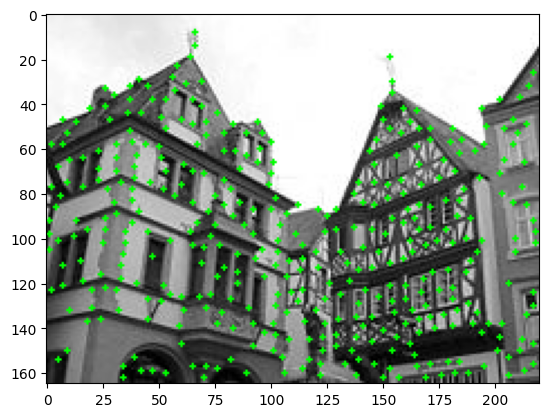

In [12]:
image = cv2.imread(r"image/img.jpg")
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

corner_list = cv2.goodFeaturesToTrack(gray_image, maxCorners=500, qualityLevel=0.01, minDistance=5)
corner_list = np.float32(corner_list)

for corner in corner_list:
    x, y = corner[0]
    x = int(x)
    y = int(y)
    cv2.circle(image, (x, y), 1, (0, 255, 0), -1)

plt.imshow(image)

# **Lucade-Kanade method**

1. Lucas-Kanade method is basically an estimate of the movement of interesting features in successive images of a scene. </br>

2. Lucas-Kanade assumes </br>
    a) that the intensity of the pixel does not change when it moves from frame1(I1) to frame(I2) with displacement (u,v): </br>
   	**<center> I1(x,y) = I2(x+u, y+v) </center>** </br>

    b) small motion, i.e (u, v) < 1 pixel </br>
    &emsp; I2 in Taylor series: </br>
    **<center> I2(x+u, y+v) = I2(x,y) + I2x(u) + I2y(v) + higher_order_terms  </br>
	                        ~ I2(x,y) + I2x(u) + I2y(v) </center>** </br>

3. Lucas-Kanade associate a movement vector to every pixel in a scene obtained by comparing the two consecutive images or frames. </br>

4. Works by trying to guess in which direction an object has moved so that local changes in intensity can be explained. </br>

5. Optical Flow has a constraint equation to be solved: </br>
**<center> Ix.u + Iy.v +It = 0 ; (this equation is obtained by substituting 2b in 2a) </center>** </br>
where,
<center> Ix : derivative of I in x-direction </br>
		 Iy : derivative of I in y-direction </br>
		 It : derivative of I over time (t) </br>
		 Ix and Iy are image gradients, and It is along t axis since now we deal with a </br>
		 third dimension. </center>

6. Smoothing the image first to attenuate any noise using Gaussian Smoothing as preprocessing

7. Using an averaging/smoothing filter of 2x2 size to find the first derivative of the smoothed image.

### **Aperture Problem**

It looks like the line is moving up and to the right. However, the right answer is that we do not know in which direction this line is moving. Actually, it can move in any direction. That is because we are looking at the line through a small circle. If we make this aperture transparent we can see that actual movement of the line is horizontal. 

<center> <img src="https://media5.datahacker.rs/2021/01/movie1-2-1.gif"> </center>

This means that we are only able to measure the component of optical flow that is in the direction of the gradient intensity. On the other hand, we are unable to measure the component perpendicular to the gradient intensity.

### **Lucas-Kanade Function**

In [13]:
# Function: Lucas-Kanade Optical Flow method
# PI: Previous image (np.ndarray)
# LI: Last image (np.ndarray)
# corner_list: List corners
# window_size: Window size (tuple)
# Return: vx, vy, corner_list
def Lucas_Kanade_Optical_Flow(PI, LI, corner_list, window_size=(3, 3)):
    shape = np.shape(PI)

    # First Derivative in X, Y, XY direction
    Ix = np.diff(np.pad(LI, ((0, 0), (0, 1)), 'edge'), axis=1).reshape(shape) / 2.0
    Iy = np.diff(np.pad(LI, ((0, 1), (0, 0)), 'edge'), axis=0).reshape(shape) / 2.0
    It = LI - PI

    # Creating vx, vy
    vx = vy = np.zeros(shape)

    # Position of the current corner on the window
    row_corner, col_corner = int(np.ceil((window_size[0] - 1) / 2)), int(np.ceil((window_size[1] - 1) / 2))

    # Plot features
    for corner in corner_list:
        x, y = corner[0].astype(int)

        # Calculating the derivatives for the neighbouring pixels
        # Size of window is window_size
        IX = Ix[y - row_corner:y + row_corner + 1, x - col_corner:x + col_corner + 1].ravel(order = 'K')
        IY = Iy[y - row_corner:y + row_corner + 1, x - col_corner:x + col_corner + 1].ravel(order = 'K')
        IT = It[y - row_corner:y + row_corner + 1, x - col_corner:x + col_corner + 1].ravel(order = 'K')

        # Solve the matrix equation using least square solution: https://www.youtube.com/watch?v=vGowBXcur1k
        A = np.column_stack((IX, IY))
        v, _, _, _ = np.linalg.lstsq(a=A, b=IT, rcond=None)

        vx[y][x], vy[y][x] = v[0], v[1]
    return vx, vy

## **Plot image - Plot video**

In [14]:
# Function: Plot Optical Flow
# PI: Previous image (np.ndarray)
# LI: Last image (np.ndarray)
# vx: vx (np.ndarray)
# vy: vy (np.ndarray)
# fig_size: Figure size (tuple)
# threshold: Threshold
# Result: Plot vector on the previous image
def plot_image_optical_flow(PI, LI, corner_list, vx, vy, fig_size=(10, 10), threshold=0.3):
    # Create some random colors
    color = np.random.randint(0,255,(1,3))
    fig = plt.figure()
    fig.set_figwidth(fig_size[0])
    fig.set_figheight(fig_size[1])

    # Plotting the vectors on the image
    plt.subplot(3, 1, 2)
    plt.title('Image 2')
    plt.imshow(LI)

    plt.subplot(3, 1, 3)
    plt.title('Plotting vector')
    plt.imshow(LI)

    for corner in corner_list:
        x, y = corner[0]
        x = int(x)
        y = int(y)
        if abs(vx[y][x]) > threshold or abs(vy[y][x]) > threshold: # setting the threshold to plot the vectors
            cv2.circle(PI, (x, y), 3, color[0].tolist(), -1)
            plt.arrow(x, y, vy[y][x], vx[y][x], head_width = 5, head_length = 5, color = 'g')
    
    plt.subplot(3, 1, 1)
    plt.title('Image 1')
    plt.imshow(PI)

In [15]:
# Function: Plot Optical Flow
# PI: Previous image (np.ndarray)
# LI: Last image (np.ndarray)
# vx: vx (np.ndarray)
# vy: vy (np.ndarray)
# fig_size: Figure size (tuple)
# threshold: Threshold
# Result: Plot vector on the previous image
def plot_video_optical_flow(frame, corner_list, mask, vx, vy, threshold=0.3, title="image", color=(0, 255, 0)):
    for i, corner in enumerate(corner_list):
        x, y = corner[0].astype(int)
        if abs(vx[y][x]) > threshold or abs(vy[y][x]) > threshold: # setting the threshold to plot the vectors
            # cv2.circle(frame, (x, y), 5, color[i].tolist(), -1)
            mask = cv2.line(mask, (x, y), (int(x + vx[y][x]), int(y + vy[y][x])), 
                            color = color[i], thickness = 3)
        
    img = cv2.add(frame, mask)
    cv2.imshow(title, img)
    return mask

### **Test Lucas-Kanade function with two frames**

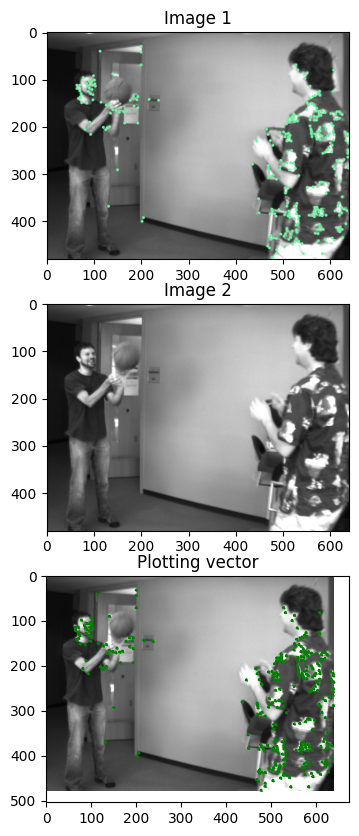

In [16]:
threshold = 0.3
num_corners = 10000
window_size = (15, 15)
fig_size = (10, 10)

image1 = cv2.imread(r"image/basketball1.png")
gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

image2 = cv2.imread(r"image/basketball2.png")
gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Shimotasi Corner Detector
corner_list = cv2.goodFeaturesToTrack(gray_image1               , 
                                      maxCorners   = num_corners, 
                                      qualityLevel = 0.03       , 
                                      minDistance  = 5           )

vx, vy = Lucas_Kanade_Optical_Flow(PI          = gray_image1, 
                                   LI          = gray_image2, 
                                   corner_list = corner_list, 
                                   window_size = window_size )

plot_image_optical_flow(PI          = image1     , 
                        LI          = image2     , 
                        corner_list = corner_list,
                        vx          = vx         , 
                        vy          = vy         , 
                        fig_size    = fig_size   , 
                        threshold   = threshold   )

### **Test Lucas-Kanade function with video**

In [20]:
window_size = (15, 15)
threshold = 0.03
num_corners = 10000
resize_ratio = 3.5
video_path = "video/cars.mp4"

# Read video
cap = cv2.VideoCapture(video_path)

# Take the first frame of the video
# ret: boolean return value, used to check whether the reading was successful
# first_frame: the first frame in the entire video sequence
ret, old_frame = cap.read()
shape = (int(old_frame.shape[1] / resize_ratio), int(old_frame.shape[0] / resize_ratio))
old_frame = cv2.resize(old_frame, shape)
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

# Create some random colors
color = np.random.randint(0,255,(num_corners,3))
color = [c.tolist() for c in color]

corner_list = cv2.goodFeaturesToTrack(old_gray                  , 
                                      maxCorners   = num_corners, 
                                      qualityLevel = 0.3        , 
                                      minDistance  = 7          ,
                                      blockSize    = 7           )

while(True):
    ret, frame = cap.read()
    if not ret:
        break
    start = time.time()
    frame = cv2.resize(frame, shape)
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate Optical flow
    vx, vy = Lucas_Kanade_Optical_Flow(PI          = old_gray   , 
                                       LI          = frame_gray , 
                                       corner_list = corner_list, 
                                       window_size = window_size )

    end = time.time()
    fps = 1. / (end - start)

    # describe the type of font
    # to be used.
    font = cv2.FONT_HERSHEY_SIMPLEX
  
    # Use putText() method for
    # inserting text on video
    cv2.putText(frame, 
                str(round(fps, 2)) + " fps", 
                (0, shape[1]), 
                font, 1, 
                (100, 255, 0), 
                2, 
                cv2.LINE_4)

    # Plot vector
    mask = plot_video_optical_flow(frame       = frame      , 
                                   corner_list = corner_list, 
                                   mask        = mask       , 
                                   vx          = vx         , 
                                   vy          = vy         , 
                                   threshold   = threshold  , 
                                   title       = "Cars"     , 
                                   color       = color       )

    if cv2.waitKey(30) & 0xff == 27: # Escape
        break

    # Now update the previous frame
    old_gray = frame_gray.copy()
    corner_list = cv2.goodFeaturesToTrack(old_gray                  , 
                                          maxCorners   = num_corners, 
                                          qualityLevel = 0.3        , 
                                          minDistance  = 7          , 
                                          blockSize    = 7           )

cv2.destroyAllWindows()
cap.release()

# **Compare to OpenCV**

In [21]:
cap = cv2.VideoCapture(video_path)

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 10000,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0,255,(10000,3))

# Take first frame and find corners in it
ret, old_frame = cap.read()
shape = (int(old_frame.shape[1] / resize_ratio), int(old_frame.shape[0] / resize_ratio))
old_frame = cv2.resize(old_frame, shape)
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

while(True):
    ret, frame = cap.read()
    if not ret:
        break
   
    frame = cv2.resize(frame, shape)
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]

  

    # describe the type of font
    # to be used.
    font = cv2.FONT_HERSHEY_SIMPLEX
 
    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (int(a),int(b)),(int(c),int(d)), color[i].tolist(), 2)
        # frame = cv2.circle(frame,(int(a),int(b)),5,color[i].tolist(),-1)
    img = cv2.add(frame,mask)

    cv2.imshow('frame',img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

cv2.destroyAllWindows()
cap.release()

## **Expand for Dense Optical Flow**

In [22]:
def plot_video_optical_flow_dense(img, vx, vy, stride=10):
    height, width = img.shape[:2]
    
    for i in range(0, height, stride):
        for j in range(0, width, stride):
            cv2.arrowedLine(img, (j, i), (int(j + vx[i][j]), int(i + vy[i][j])), color=(0, 255, 255),
                            thickness=1)
    cv2.imshow("frame", img)

In [23]:
window_size = (15, 15)
threshold = 0.03
num_corners = 10000
resize_ratio = 3.5
stride = 10
video_path = "video/cars.mp4"

# Read video
cap = cv2.VideoCapture(video_path)

# Take the first frame of the video
# ret: boolean return value, used to check whether the reading was successful
# first_frame: the first frame in the entire video sequence
ret, old_frame = cap.read()
shape = (int(old_frame.shape[1] / resize_ratio), int(old_frame.shape[0] / resize_ratio))
old_frame = cv2.resize(old_frame, shape)
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

# Create some random colors
color = np.random.randint(0,255,(int(shape[0] * shape[1]),3))
color = [c.tolist() for c in color]

corner_list = []
size = int(window_size[0]/2) + 1
curr_row = 0
curr_col = 0
for i in range (size, old_gray.shape[0] - size, stride): 
    for j in range(size, old_gray.shape[1] - size, stride):
        corner_list.append([[j, i]])
corner_list = np.asarray(corner_list)

while(True):
    ret, frame = cap.read()
    if not ret:
        break
    start = time.time()
    frame = cv2.resize(frame, shape)
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate Optical flow
    vx, vy = Lucas_Kanade_Optical_Flow(PI          = old_gray   , 
                                       LI          = frame_gray , 
                                       corner_list = corner_list, 
                                       window_size = window_size )

    end = time.time()
    fps = 1. / (end - start)

    # describe the type of font
    # to be used.
    font = cv2.FONT_HERSHEY_SIMPLEX
  
    # Use putText() method for
    # inserting text on video
    cv2.putText(frame, 
                str(round(fps, 2)) + " fps", 
                (0, shape[1]), 
                font, 1, 
                (100, 255, 0), 
                2, 
                cv2.LINE_4)

    # Plot vector
    plot_video_optical_flow_dense(frame, vx, vy, stride = stride)

    if cv2.waitKey(30) & 0xff == 27: # Escape
        break

    # Now update the previous frame
    old_gray = frame_gray.copy()

cv2.destroyAllWindows()
cap.release()

# Camera

In [24]:
window_size = (15, 15)
threshold = 0.03
num_corners = 10000
resize_ratio = 3.5
stride = 10


# Read video
cap = cv2.VideoCapture(0)

# Take the first frame of the video
# ret: boolean return value, used to check whether the reading was successful
# first_frame: the first frame in the entire video sequence
ret, old_frame = cap.read()
shape = (int(old_frame.shape[1] / resize_ratio), int(old_frame.shape[0] / resize_ratio))
old_frame = cv2.resize(old_frame, shape)
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

# Create some random colors
color = np.random.randint(0,255,(int(shape[0] * shape[1]),3))
color = [c.tolist() for c in color]

corner_list = []
size = int(window_size[0]/2) + 1
curr_row = 0
curr_col = 0
for i in range (size, old_gray.shape[0] - size, stride): 
    for j in range(size, old_gray.shape[1] - size, stride):
        corner_list.append([[j, i]])
corner_list = np.asarray(corner_list)

while(True):
    ret, frame = cap.read()
    # if not ret:
    #     break

    frame = cv2.resize(frame, shape)
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate Optical flow
    vx, vy = Lucas_Kanade_Optical_Flow(PI          = old_gray   , 
                                       LI          = frame_gray , 
                                       corner_list = corner_list, 
                                       window_size = window_size )


    # describe the type of font
    # to be used.
    font = cv2.FONT_HERSHEY_SIMPLEX
 

    # Plot vector
    plot_video_optical_flow_dense(frame, vx, vy, stride = stride)

    if cv2.waitKey(30) & 0xff == 27: # Escape
        break

    # Now update the previous frame
    old_gray = frame_gray.copy()

cv2.destroyAllWindows()
cap.release()

# Camera OPENCV

In [25]:
cap = cv2.VideoCapture(0)

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 10000,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0,255,(10000,3))

# Take first frame and find corners in it
ret, old_frame = cap.read()
shape = (int(old_frame.shape[1] / resize_ratio), int(old_frame.shape[0] / resize_ratio))
old_frame = cv2.resize(old_frame, shape)
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

while(True):
    ret, frame = cap.read()
    if not ret:
        break
 
    frame = cv2.resize(frame, shape)
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]

   
    # describe the type of font
    # to be used.
    font = cv2.FONT_HERSHEY_SIMPLEX
 
    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new,good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (int(a),int(b)),(int(c),int(d)), color[i].tolist(), 2)
        # frame = cv2.circle(frame,(int(a),int(b)),5,color[i].tolist(),-1)
    img = cv2.add(frame,mask)

    cv2.imshow('frame',img)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

cv2.destroyAllWindows()
cap.release()